In [5]:
from __future__ import division, print_function
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import make_interp_spline
from scipy import stats
from scipy import optimize
from sklearn.decomposition import PCA
from scipy.integrate import quad
from matplotlib.pyplot import cm
from numpy.polynomial import polynomial
import hashlib
import os
import glob
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [260]:
def msu(coseta, p1=0.3, p2=0):
    '''
    MSU parameterization 
    https://wiki.icecube.wisc.edu/index.php/MSU_Forward_Hole_Ice
    '''
    f = lambda x : 0.34 * (1 + 1.5 * x - x**3/2.) + p1 * x * (x**2 -1)**3 +p2 * np.exp(10*(x-1.2))
    norm = quad(f, -1, 1)
    return f(coseta) * 0.68 / norm[0]

# Load some angular acceptance models

In [520]:
xnew = np.linspace(-1,1,101)

models = {}
files = [f for f in glob.glob('/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.*')]
for file in files:
    #print(file)
    with open(file, 'r') as m:
        poly = m.readlines()
        poly = [float(c.strip()) for c in poly]
        f = polynomial.Polynomial(poly[1:])
        models[file.split('.')[-1]] = f(xnew)
        
# from Martin R.
f = polynomial.Polynomial([ 2.06777114e-14,  1.74719461e-14, -5.67238286e-14, -3.42800409e-14,  4.95514301e-14, -7.42966323e-02, -5.41036322e-03, -9.07768380e-02, -8.56063000e-02, 4.30334072e-01,  3.55900800e-01][::-1])
norm = quad(f, -1, 1)
models['martin_0.6_14'] = f(xnew) * 0.68 / norm[0]
f = polynomial.Polynomial([ 3.36087298e-14,  1.36499579e-14, -7.97723716e-14, -2.26422656e-14,  6.30906222e-14, -2.46424084e-01, -2.53383207e-01, -4.97533265e-02,  8.79281247e-02,  4.82721282e-01,  3.52484462e-01][::-1])
norm = quad(f, -1, 1)
models['martin_0.8_40'] = f(xnew) * 0.68 / norm[0]
f = polynomial.Polynomial([-2.32400791e-14,  1.17692970e-14,  4.23202843e-14, -2.87362984e-14, -2.51280360e-14, -5.00046160e-01, -6.38566738e-01,  7.87329961e-02,  3.45636471e-01,  4.76239349e-01,  3.51226068e-01][::-1])
norm = quad(f, -1, 1)
models['martin_1.8_125'] = f(xnew) * 0.68 / norm[0]

models['greco'] = msu(xnew, p1=(0.3+0.49*0.1), p2=-0.63)
models['dragon'] = msu(xnew, p1=(0.3-0.25*0.1), p2=-1.15)
models['baseline'] = msu(xnew, p1=(0.3), p2=-1)
models['msu2'] = msu(xnew, p1=(0.3), p2=1)
models['dima'] = msu(xnew, p1=(0.3), p2=0)
models['dima+'] = msu(xnew, p1=(0.4), p2=0)
models['dima-'] = msu(xnew, p1=(0.2), p2=0)

/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.flasher_p1_0.30_p2_-1
/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.flasher_p1_0.25_p2_-2
/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.h3-30cm
/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.flasher_p1_0.20_p2_0
/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.flasher_p1_0.30_p2_-3
/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.flasher_p1_0.35_p2_0
/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.flasher_p1_0.25_p2_+2
/cvmfs/icecube.opensciencegri

In [521]:
# only select the ones we are interested in


#models = {k: models[k] for k in ['h1-100cm', 'h2-50cm', 'h3-30cm', 'nominal', '30_p2_0', '25_p2_0', '35_p2_0', 'dragon', 'greco', 'baseline', '30_p2_+1']}
models = {k: models[k] for k in ['nominal', 'h1-100cm', 'h2-50cm', 'h3-30cm', 'dima', 'dima+', 'dima-', 'dragon', 'greco', 'baseline', 'msu2', 'martin_0.6_14', 'martin_0.8_40', 'martin_1.8_125']}
#models = {k: models[k] for k in ['nominal', 'dima', 'dima+', 'dima-', 'dragon', 'greco', 'baseline', 'msu2', 'martin_0.6_14', 'martin_0.8_40', 'martin_1.8_125']}

#allmodels['old_bestfit'] = old_bestfit

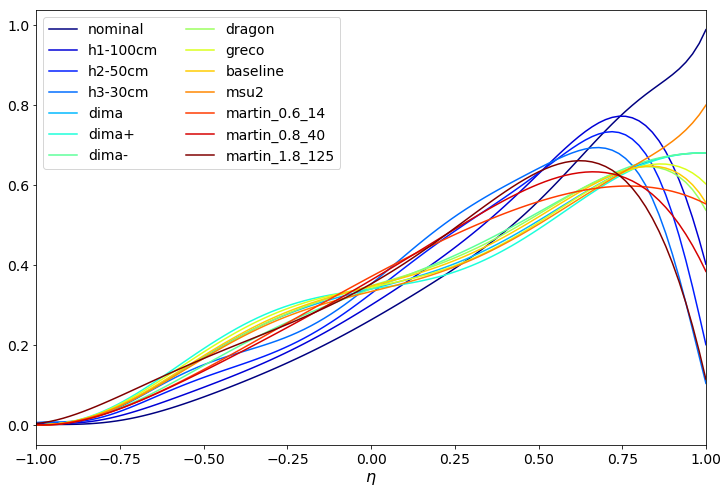

In [482]:
colors = cm.jet(np.linspace(0,1,len(models)))

for target, name, color in zip(models.values(), models.keys(), colors):
    plt.plot(xnew, target, label=name, c=color)

plt.gca().set_xlim([-1,1])
plt.gca().set_xlabel(r'$\eta$')
plt.gca().legend(loc='upper left', ncol=2)
plt.savefig('all.png')

# Approximate those by splines

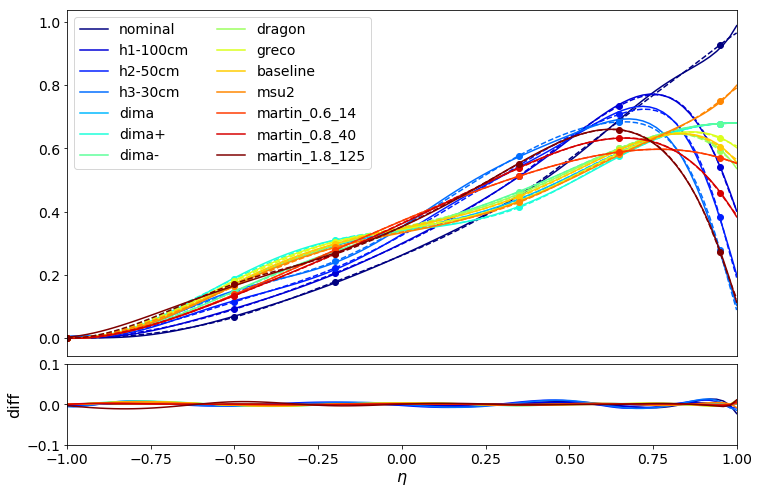

In [483]:
#support_x = np.array([-1., -0.5, -0.2, 0.2, 0.5, 0.75, 0.97, 1.])
support_x = np.array([-1., -0.5, -0.2, 0.35, 0.65, 0.95, 1.05])


# new
#support_x = np.array([-1., -0.6,  0.2, 0.6, 0.75, 0.9, 1.])


#support_x = np.array([-1.  , -0.6 , -0.25,  0.1 ,  0.5 ,  0.9 ,  1.  ])

initial_y = np.ones_like(support_x) * 0.5

# this sets the derivative=0 boundary conditions
bc_type=([(1, 0.0)], [(1, 0.0)])
#bc_type=None

def fun(y, support_x, target):
    '''
    Minimizer objective
    '''
    # we fix the leftmost point to 0
    y[0] = 0
    cubic = make_interp_spline(support_x, y, bc_type=bc_type)
    diff = target - cubic(xnew)
    return np.sqrt(np.sum(np.square(diff)))

fig = plt.figure()
ax1 = plt.subplot2grid((10,1), (0,0), rowspan=8, fig=fig)
ax2 = plt.subplot2grid((10,1), (8,0),sharex=ax1,rowspan=2, fig=fig)

y_points = []

for target, name, color in zip(models.values(), models.keys(), colors):
    opt = optimize.minimize(fun, x0=initial_y, method='L-BFGS-B', args=(support_x, target))
    y = opt['x']
    y_points.append(y)

    cubic = make_interp_spline(support_x, y, bc_type=bc_type)
    ax1.plot(support_x, y, 'o', c=color)
    ax1.plot(xnew, cubic(xnew), '--', c=color)
    ax1.plot(xnew, target, label=name, c=color)
    ax2.plot(xnew, cubic(xnew) - target, c=color)

y_points = np.stack(y_points)

ax1.set_xlim([-1,1])
ax2.set_xlim([-1,1])
ax1.get_xaxis().set_visible(False)

ax2.set_ylim([-0.1, 0.1])
ax2.hlines(0,-1,1)
ax2.set_ylabel('diff')
ax2.set_xlabel(r'$\eta$')

ax1.legend(loc='best', ncol=2)
plt.show()
fig.savefig('approx.png')

# Reduce dimensionality
by doing a PCA decomposition and taking the two most important components

In [484]:
n_components=2

transformer = PCA(n_components=n_components, random_state=0)
out = transformer.fit_transform(y_points)

print(transformer.explained_variance_)
print(transformer.singular_values_)

[0.12035492 0.00565398]
[1.25084529 0.27111212]


-4.7580986769649563e-17 2.9913031054585857
-2.1312316990572203e-17 13.801143807506353


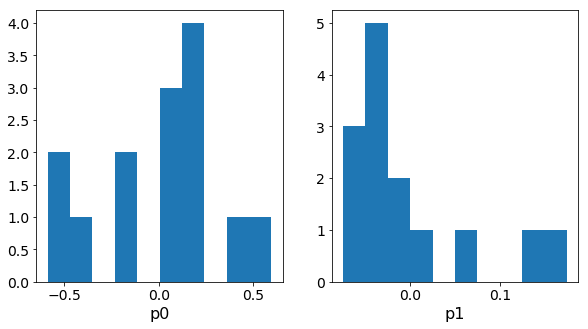

In [485]:
# let's investigate the interesting parameter ranges

fig = plt.figure(figsize=(15,5))
for i in range(out.shape[1]):
    ax = plt.subplot2grid((1,out.shape[1]+1), (0,i), rowspan=1, fig=fig)
    ax.hist(out[:,i])
    ax.set_xlabel('p%i'%i)
    print(np.mean(out[:,i]), 1./ np.std(out[:,i]))
plt.savefig('dist.png')

In [486]:
# now then build a function with 2 parameters

def ang(params, values):
    '''
    New angular acceptance funcion
    
    params : list / array
        the two parametrrs p1 and p2
    values : array
        the eta values to compute the angular acceptance for in (-1, 1)
    '''
    transformed_params = transformer.inverse_transform(params)
    f = make_interp_spline(support_x, transformed_params, bc_type=bc_type)
    positive_f = lambda x : np.clip(f(x), 0., None)
    
    norm = quad(positive_f, -1, 1)
    out = positive_f(values)
    #normalize....why 0.68?
    out /= norm[0] / 0.68
    
    return out

# Samples & Envelope
let's do some random sampling of the new function

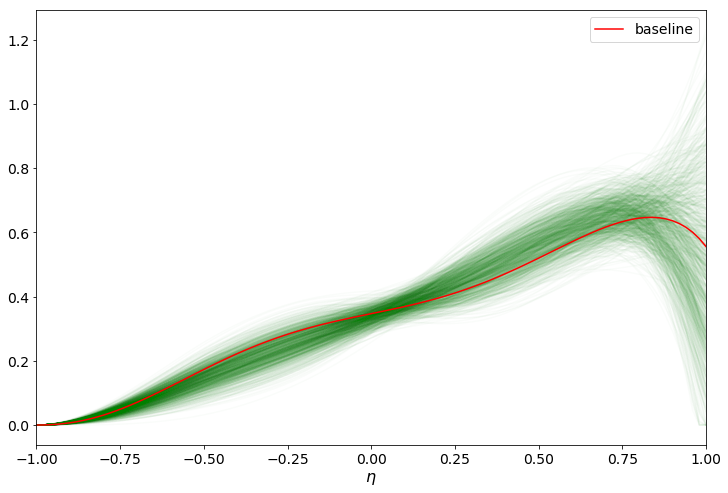

In [985]:
n = 1000

all_curves = np.ones(shape=(n, xnew.shape[0]))

for i in range(n):
    params = []
    for j in range(out.shape[1]):
        r = np.random.randn(1)
        params.append(r[0] * np.std(out[:,j]))
    all_curves[i] = ang(params, xnew)
    plt.plot(xnew, all_curves[i], c='green', alpha=20./n)
    #plt.plot(xnew, cubic(xnew), c='green', alpha=20./n)
                
plt.gca().set_xlim([-1,1])    
#plt.plot(xnew, msu(xnew, p1=0.2, p2=0), c='k')
plt.plot(xnew, models['baseline'], c='r', label='baseline')
#plt.plot(xnew, msu(xnew, p1=0.4, p2=0), c='k')
plt.legend()
plt.gca().set_xlabel(r'$\eta$')
plt.savefig('rand.png')

In [986]:
p16 = np.percentile(all_curves, 16, axis=0)
p84 = np.percentile(all_curves, 86, axis=0)
p25 = np.percentile(all_curves, 2.5, axis=0)
p975 = np.percentile(all_curves, 97.5, axis=0)
p50 = np.percentile(all_curves, 50, axis=0)

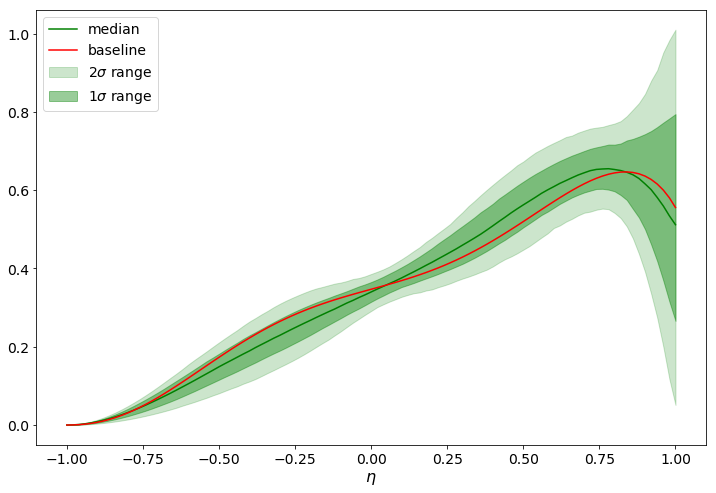

In [987]:
plt.fill_between(xnew, p25, p975, alpha=0.2, color='green', label=r'2$\sigma$ range')
plt.fill_between(xnew, p16, p84, alpha=0.4, color='green', label=r'1$\sigma$ range')
plt.plot(xnew, p50, color='g', label='median')
plt.plot(xnew, models['baseline'], c='r', label='baseline')
plt.gca().set_xlabel(r'$\eta$')
plt.legend(loc='upper left')
plt.savefig('envelope.png')

# Fit back to original models
How good does it approximate the original functions?

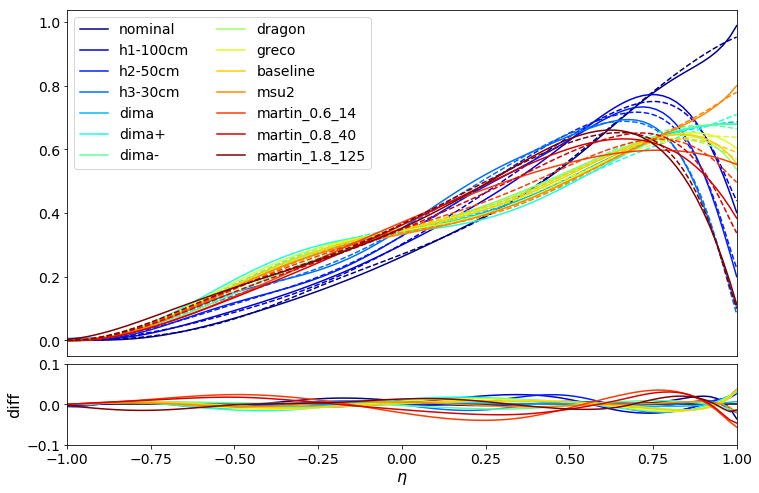

In [499]:
def fun(params, target):
    diff = ang(params, xnew) - target
    return np.sqrt(np.sum(np.square(diff)))

fig = plt.figure()
ax1 = plt.subplot2grid((10,1), (0,0), rowspan=8, fig=fig)
ax2 = plt.subplot2grid((10,1), (8,0),sharex=ax1,rowspan=2, fig=fig)

new_params = {}

for target, name, color in zip(models.values(), models.keys(), colors):
    
    opt = optimize.minimize(fun, x0=np.zeros(out.shape[1]), method='BFGS', args=(target)) 
    new_params[name] = opt['x']

    new = ang(opt['x'], xnew)
    ax1.plot(xnew, new, '--', c=color)
    ax1.plot(xnew, target, label=name, c=color)
    ax2.plot(xnew, new - target, c=color)


ax1.set_xlim([-1,1])
ax2.set_xlim([-1,1])
ax1.get_xaxis().set_visible(False)

ax2.set_ylim([-0.1, 0.1])
ax2.hlines(0,-1,1)
ax2.set_ylabel('diff')
ax2.set_xlabel(r'$\eta$')

ax1.legend(loc='upper left', ncol=2)
plt.show()
fig.savefig('approx_new.png')

# morph from one to another model
Let's have some fun by morphing from dima to H2 in a couple intermediate steps

/home/peller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


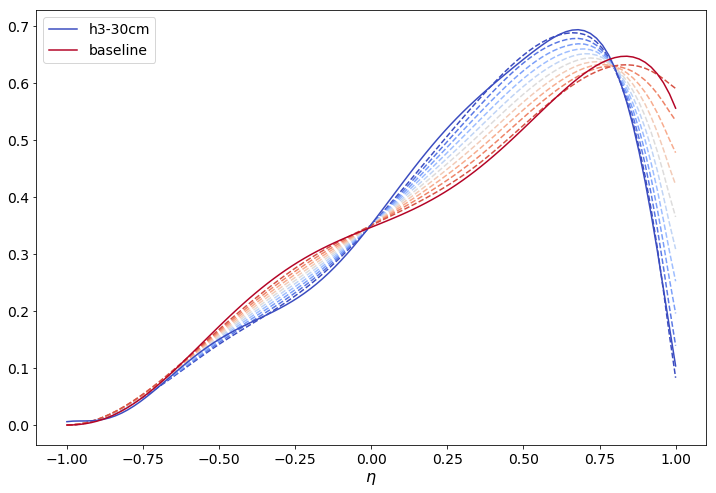

In [989]:
n = 10.

m2 = 'baseline'
m1 = 'h3-30cm'

param_space = np.zeros((int(n), n_components))

for i in range(n_components):
    param_space[:,i] = np.linspace(new_params[m1][i], new_params[m2][i], n, endpoint=True)

cmap = cm.coolwarm

for i in range(int(n)):
    plt.plot(xnew, ang(param_space[i], xnew), c=cmap(i/n), ls='--')
    
plt.plot(xnew, models[m1], color=cmap(0.), label=m1)
plt.plot(xnew, models[m2], color=cmap(1.), label=m2)
plt.legend()
plt.gca().set_xlabel(r'$\eta$')

plt.savefig('morph.png')

In [501]:
import pandas as pd
df = pd.DataFrame(new_params)
df = df.transpose()
df.columns = ['p0', 'p1']
df

,p0,p1
nominal,0.567771,0.168269
h1-100cm,-0.123027,0.131104
h2-50cm,-0.405128,0.075841
h3-30cm,-0.595997,0.017468
dima,0.232258,-0.042754
dima+,0.265798,-0.070837
dima-,0.198792,-0.014733
dragon,0.072961,-0.043175
greco,0.167150,-0.060809
baseline,0.101569,-0.049344


# make it into a small python module

In [502]:
module_src = '''from __future__ import division, print_function
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import make_interp_spline
from numpy.polynomial import polynomial

# these values are obtained from a fit (explained in https://github.com/philippeller/angular_acceptance/blob/master/Angular_acceptance.ipynb)
'''
module_src += 'support_x = np.%s'%repr(support_x)
module_src += '\ncomponents = np.%s'%repr(transformer.components_)
module_src += '\nmean = np.%s'%repr(transformer.mean_)
module_src += '\nn_components = %s'%n_components
module_src += '''

def ang(params, values):
    """
    New angular acceptance function
    
    params : list / array
        the parameters p0, p1, ...
    values : float, list, array
        the eta values to compute the angular acceptance for in (-1, 1)
    """
    # sanity check
    assert np.all(np.logical_and(np.greater_equal(values, -1), np.less_equal(values, 1))), 'values must be in range -1, 1'
    p = np.zeros(n_components)
    p[:len(params)] = params
    # inverse PCA transform
    transformed_params = np.dot(p, components) + mean
    # construct spline
    f = make_interp_spline(support_x, transformed_params, bc_type=([(1, 0.)], [(1, 0.)]))
    # make sure we're positive everywhere
    positive_f = lambda x : np.clip(f(x), 0., None)
    # normalize
    norm = quad(positive_f, -1, 1)
    out = positive_f(values)
    #normalize....why 0.68?
    out *= 0.68 / norm[0]
    return out
    
def angsens_poly(params):
    """
    Return standard IceCube format
    
    params : list/array
        the parameters p0, p1, ... 
    """
    
    x = np.linspace(-1,1,101)
    sampled = ang(params, x)
    coeffs = np.zeros(12)
    coeffs[0] = np.max(sampled)
    coeffs[1:] = polynomial.polyfit(x, sampled, 10)
    return coeffs
    
if __name__=='__main__':
    from sys import argv
    params = [0.]*n_components
    if len(argv) > 0:
        params[:len(argv)-1] = [float(a) for a in argv[1:]]
    print('\\n'.join([str(a) for a in angsens_poly(params)]))
'''

h = hashlib.md5(module_src.encode('utf8'))
module_src = '# version %s\n'%h.hexdigest() + module_src

with open('unified_angular_acceptance.py', 'w') as f:
    f.write(module_src)

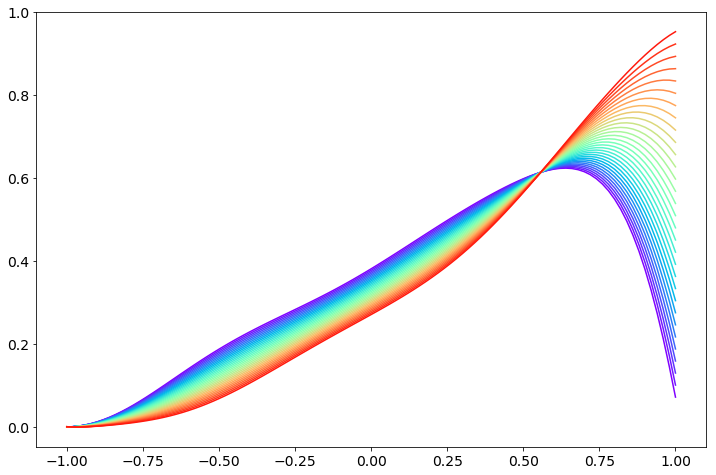

In [590]:
from unified_angular_acceptance import angsens_poly
from numpy.polynomial import polynomial
N = 31
eta = np.linspace(-1,1,101)
for i, p in enumerate(zip(np.linspace(df['p0'].min(), df['p0'].max() ,N), np.linspace(df['p1'].min(),df['p1'].max(),N))):
    coef = angsens_poly(p)
    newf = polynomial.Polynomial(coef[1:])
    plt.plot(eta, newf(eta), c=cm.rainbow(i/N))

Text(0.5, 1.0, 'p0 sweep')

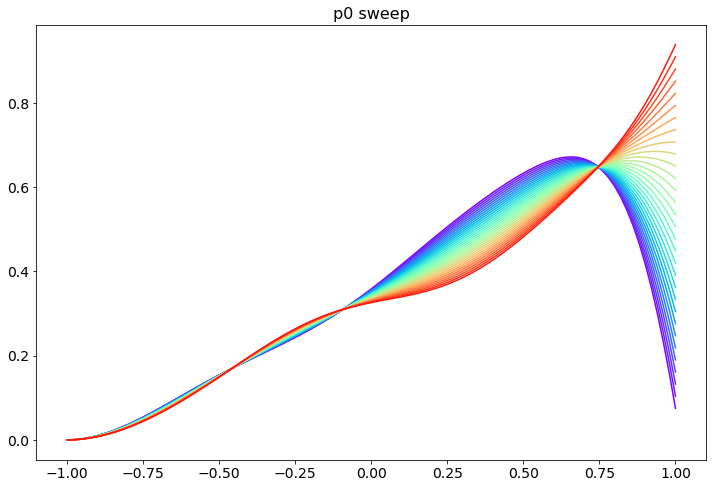

In [592]:
for i, p in enumerate(zip(np.linspace(df['p0'].min(), df['p0'].max(),N), np.linspace(df['p1'].mean(),df['p1'].mean(),N))):
    coef = angsens_poly(p)
    newf = polynomial.Polynomial(coef[1:])
    plt.plot(eta, newf(eta), c=cm.rainbow(i/N))
plt.title('p0 sweep')

Text(0.5, 1.0, 'p1 sweep')

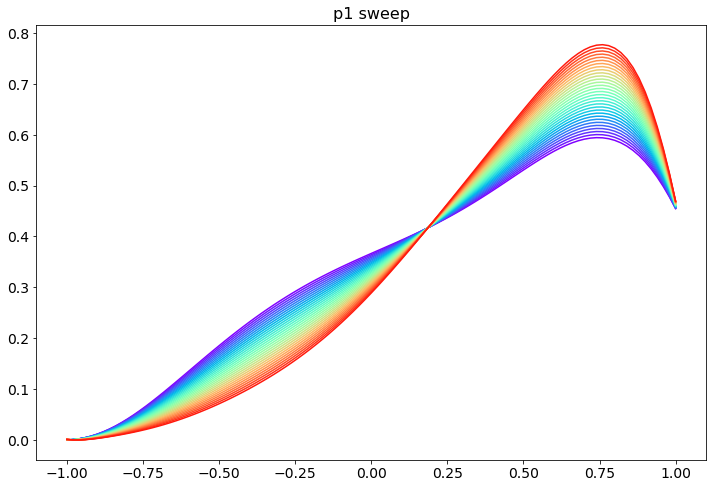

In [591]:
for i, p in enumerate(zip(np.linspace(df['p0'].mean(), df['p0'].mean() ,N), np.linspace(df['p1'].min(),df['p1'].max(),N))):
    coef = angsens_poly(p)
    newf = polynomial.Polynomial(coef[1:])
    plt.plot(eta, newf(eta), c=cm.rainbow(i/N))
plt.title('p1 sweep')  

In [504]:
print(df)

                      p0        p1
nominal         0.567771  0.168269
h1-100cm       -0.123027  0.131104
h2-50cm        -0.405128  0.075841
h3-30cm        -0.595997  0.017468
dima            0.232258 -0.042754
dima+           0.265798 -0.070837
dima-           0.198792 -0.014733
dragon          0.072961 -0.043175
greco           0.167150 -0.060809
baseline        0.101569 -0.049344
msu2            0.357705 -0.036428
martin_0.6_14  -0.028113 -0.035254
martin_0.8_40  -0.246929 -0.010401
martin_1.8_125 -0.569511 -0.034839


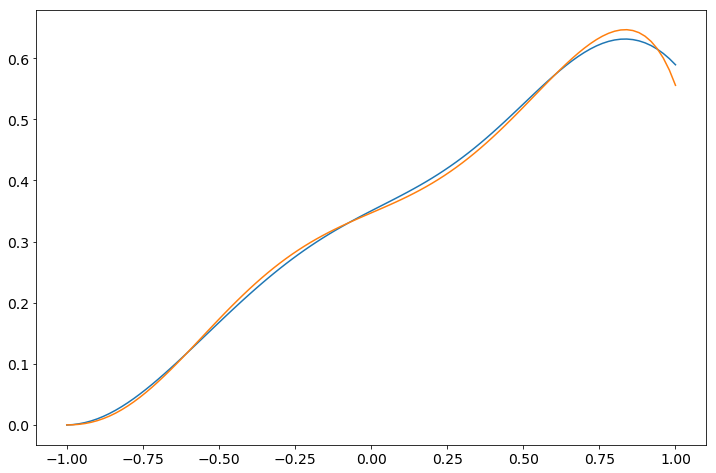

In [505]:
coef = angsens_poly(new_params['baseline'])
newf = polynomial.Polynomial(coef[1:])
plt.plot(eta, newf(eta))
plt.plot(eta, models['baseline'])

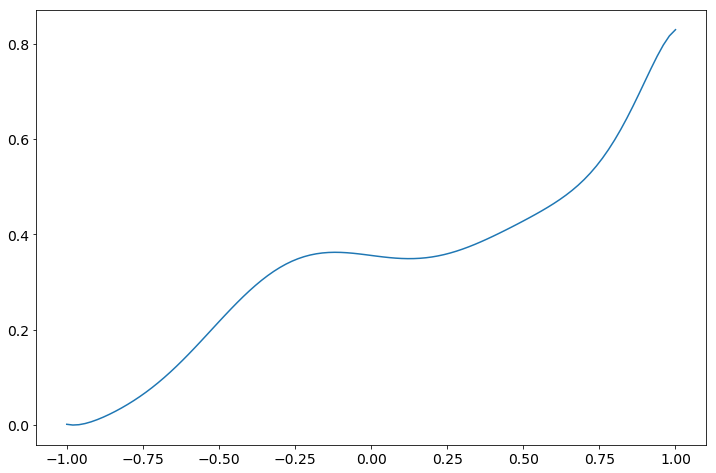

In [506]:
# best point with old fit
coeffs = [0.355793167591307, -0.08328099092179868, 0.009356988763028413, 1.9926664364470403, -1.0418634958128061, -4.334874306870165, 2.1449340674052806, 4.810474842543728, -1.0540713839822171, -1.9709623396963614, 0.0013336487140552923]
newf = polynomial.Polynomial(coeffs)
old_bestfit = newf(eta)
plt.plot(eta, old_bestfit)

opt = optimize.minimize(fun, x0=np.zeros(out.shape[1]), method='BFGS', args=(old_bestfit)) 
opt = optimize.minimize(fun, x0=opt['x'], method='BFGS', args=(old_bestfit)) 

[ 0.50023287 -0.15140584]


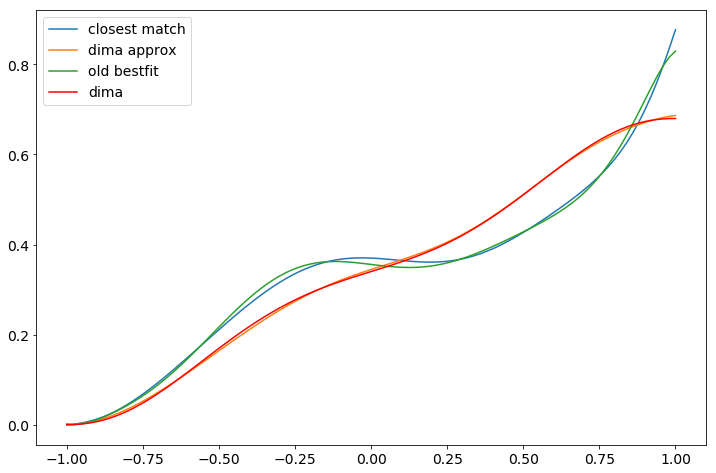

In [507]:
print(opt['x'])
coef = angsens_poly(opt['x'])
newf = polynomial.Polynomial(coef[1:])
plt.plot(eta, newf(eta), label='closest match')
coef = angsens_poly(new_params['dima'])
newf = polynomial.Polynomial(coef[1:])
plt.plot(eta, newf(eta), label='dima approx')
plt.plot(eta, old_bestfit, label='old bestfit')
plt.plot(eta, models['dima'], label='dima', c='r')
plt.legend()

In [523]:
# from dima's fit:
best_p = {}
best_p['all'] = [-0.427318  ,  -0.0675806]
best_p['tilted'] = [-0.501349  ,  -0.0876635]
best_p['horizontal'] = [-0.378935  ,  -0.0385643]


#best_p['all_div'] = [0.846887  ,  -0.481283]
#best_p['tilted_div'] = [0.944486  ,  -0.579109]
#best_p['horizontal_div'] = [0.881531  ,  -0.438632]



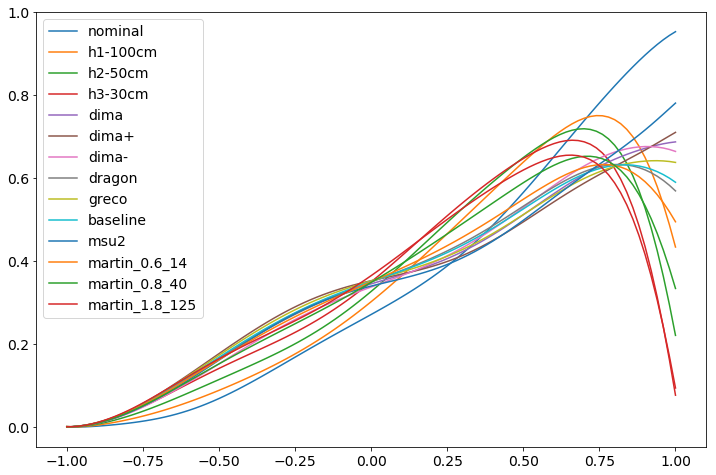

In [524]:
for fit, p in new_params.items():
    coef = angsens_poly(p)
    newf = polynomial.Polynomial(coef[1:])
    plt.plot(eta, newf(eta), label=fit)
plt.legend()

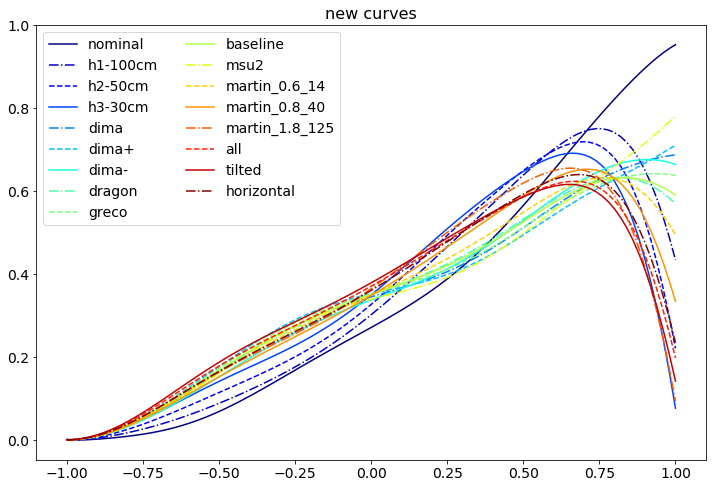

In [557]:
all_curves = {**new_params,**best_p, }

#models.pop('nominal')
#models.pop('msu2')

N = len(models) + len(best_p)

colors = cm.jet(np.linspace(0,1,N))
ls = ['-','-.','--']

#for i, (m, c) in enumerate(models.items()):
#    plt.plot(eta, c, label=m, c=colors[i], ls=ls[i%len(ls)])

    
for i, (fit, p) in enumerate(new_params.items()):
    coef = angsens_poly(p)
    newf = polynomial.Polynomial(coef[1:])
    plt.plot(eta, newf(eta), label=fit, c=colors[i], ls=ls[i%len(ls)])
    
for j, (fit, p) in enumerate(best_p.items()):
    coef = angsens_poly(p)
    newf = polynomial.Polynomial(coef[1:])
    plt.plot(eta, newf(eta), label=fit, c=colors[i+j+1], ls=ls[(i+j+1)%len(ls)])
    #plt.plot(eta, ang(p, eta), label=fit, c=colors[i+j+1], ls=ls[(i+j+1)%len(ls)])
plt.legend(ncol=2)
plt.title('new curves')
plt.savefig('busy_plot.png')

In [534]:
all_params = {**new_params ,**best_p}

In [511]:
from make_dima_msu_polynomial import msu_poly

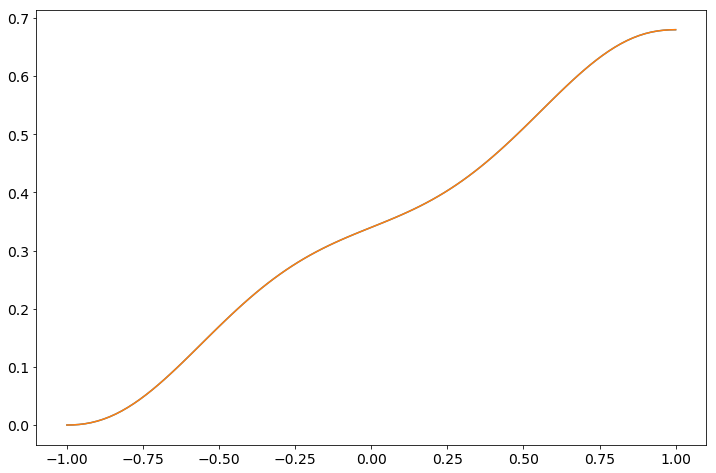

In [515]:
coef = msu_poly([0.3, 0.])
newf = polynomial.Polynomial(coef[1:])
plt.plot(eta, newf(eta), label=fit)

plt.plot(eta, models['dima'])

In [535]:
import pandas as pd
df = pd.DataFrame(all_params)
df = df.transpose()
df.columns = ['p0', 'p1']
df

,p0,p1
nominal,0.567771,0.168269
h1-100cm,-0.123027,0.131104
h2-50cm,-0.405128,0.075841
h3-30cm,-0.595997,0.017468
dima,0.232258,-0.042754
dima+,0.265798,-0.070837
dima-,0.198792,-0.014733
dragon,0.072961,-0.043175
greco,0.167150,-0.060809
baseline,0.101569,-0.049344


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c7cea2dd8>,
      dtype=object)

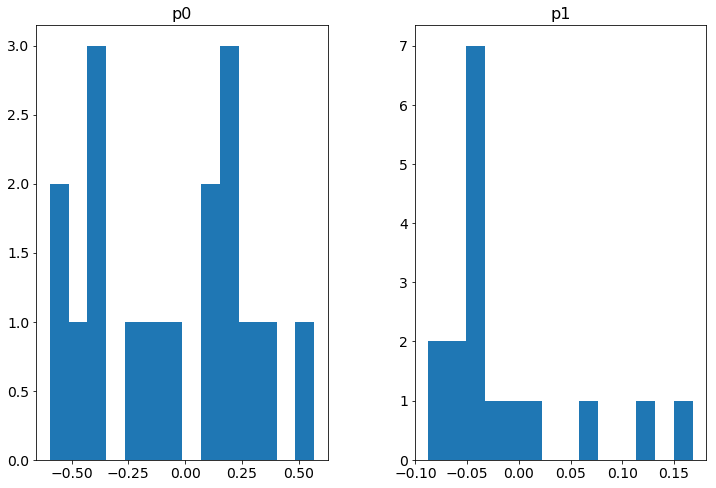

In [579]:
df.hist(grid=False, bins=14)

In [583]:
df['p0'].mean()

-0.0771942249414985

In [594]:
import seaborn as sns

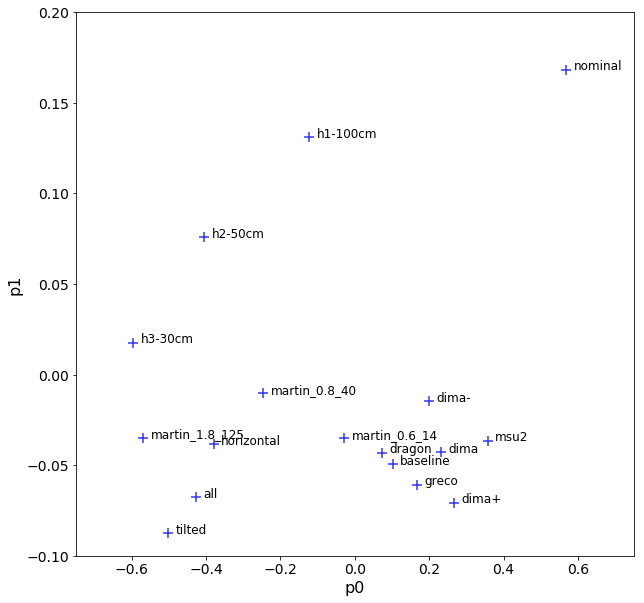

In [980]:
fig, ax = plt.subplots(figsize=(10,10))

p = sns.regplot(data=df, x="p0", y="p1", fit_reg=False, marker="+", scatter_kws={'s':100}, color="blue", ax=ax)
for line in range(0,df.shape[0]):
     p.text(df.p0[line]+0.02, df.p1[line], df.index[line], horizontalalignment='left', size='medium', color='black', fontsize=12, )
plt.gca().set_xlim((-0.75, 0.75))
plt.gca().set_ylim((-0.1, 0.2))
plt.savefig('landscape.png', dpi=600)

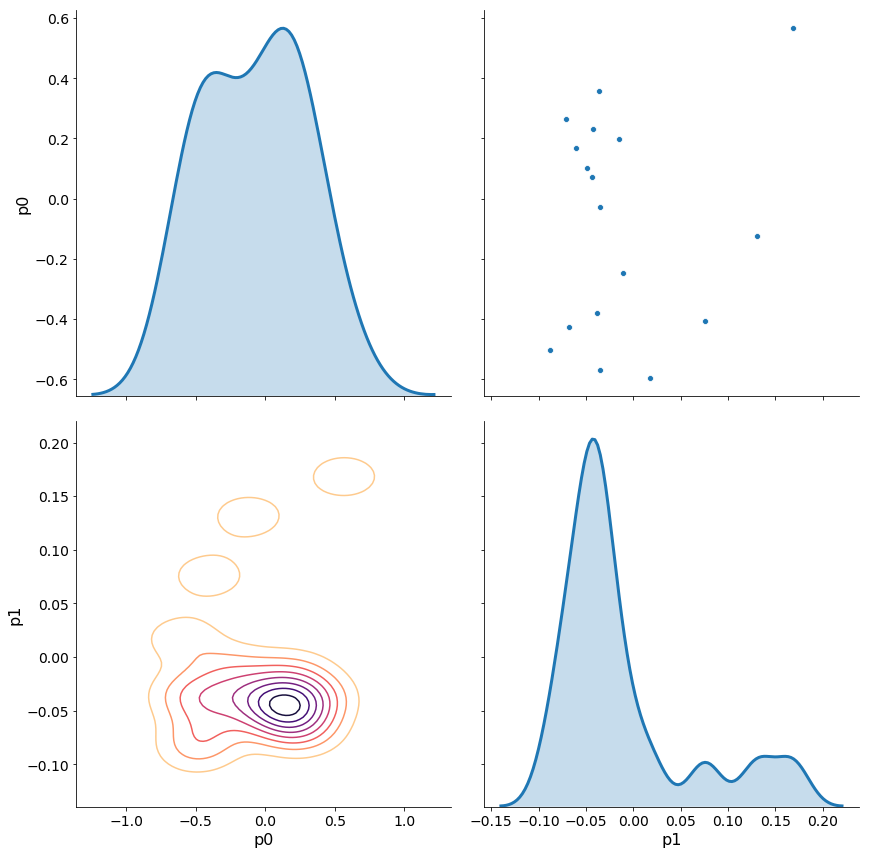

In [997]:

g = sns.PairGrid(df, diag_sharey=False, height=6)
g.map_lower(sns.kdeplot, cmap='magma_r')
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3, shade=True, )

# Generate systematics sets
spanning the interesting space in a low discrepancy sequence

In [897]:
''' from http://extremelearning.com.au/unreasonable-effectiveness-of-quasirandom-sequences/'''

import numpy as np

# Using the above nested radical formula for g=phi_d 
# or you could just hard-code it. 
# phi(1) = 1.61803398874989484820458683436563 
# phi(2) = 1.32471795724474602596090885447809 
def phi(d): 
    x=2.0000 
    for i in range(10): 
        x = pow(1+x,1/(d+1)) 
    return x

# Number of dimensions. 
d=2 

# number of required points 
n=50 

g = phi(d) 
alpha = np.zeros(d) 
for j in range(d): 
    alpha[j] = pow(1/g,j+1) %1 
sample = np.zeros((n, d)) 

# This number can be any real number. 
# Common default setting is typically seed=0
# But seed = 0.5 is generally better. 

seed = 0.5

for i in range(n): 
    sample[i] = (seed + alpha*(i+1)) %1
    
sample = sample.T

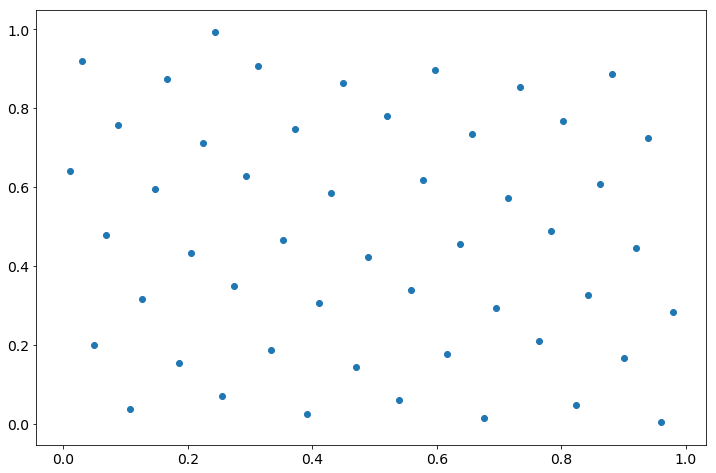

In [898]:
plt.scatter(sample[0], sample[1])
plt.title('low discrepancy series')

In [899]:
sample = pd.DataFrame([sample[0], sample[1]]).T
sample.columns = ['p0', 'p1']

In [900]:
sample = 1 - sample

In [901]:
#sample['p0'] = stats.norm.isf(sample['p0'], loc=df.loc['baseline']['p0'], scale=df.std()['p0'])
#sample['p1'] = stats.norm.isf(sample['p1'], loc=df.loc['baseline']['p1'], scale=df.std()['p1'])

sample['p0'] = stats.norm.isf(sample['p0'], loc=0.1, scale=0.25)
sample['p1'] = stats.norm.isf(sample['p1'], loc=-0.035, scale=0.05)

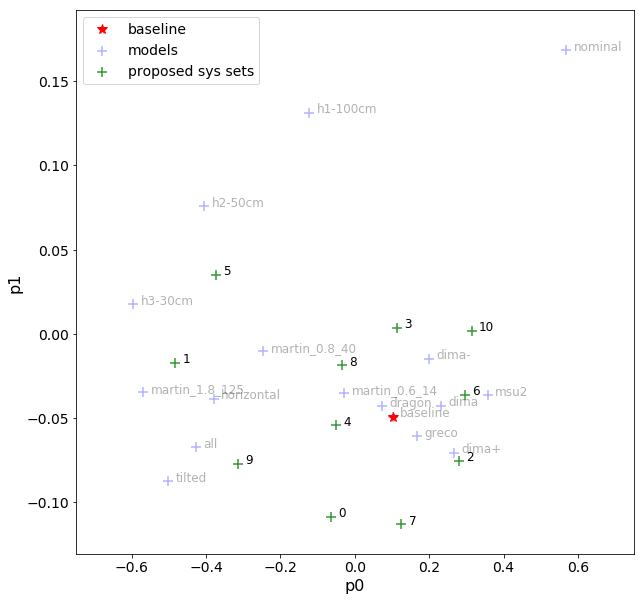

In [995]:
fig, ax = plt.subplots(figsize=(10,10))

data = sample[:11]


p = sns.regplot(data=df, x="p0", y="p1", fit_reg=False, marker="+", scatter_kws={'s':100, 'alpha':0.3}, color="blue", ax=ax, label='models')
for line in range(0,df.shape[0]):
     p.text(df.p0[line]+0.02, df.p1[line], df.index[line], horizontalalignment='left', size='medium', color='black', fontsize=12, alpha=0.3)
plt.gca().set_xlim((-0.75, 0.75))
#plt.gca().set_ylim((-0.1, 0.2))


p = sns.regplot(data=data, x="p0", y="p1", fit_reg=False, marker="+", scatter_kws={'s':100}, color="g", ax=ax, label='proposed sys sets')
for line in range(0,data.shape[0]):
     p.text(data.p0[line]+0.02, data.p1[line], data.index[line], horizontalalignment='left', size='medium', color='black', fontsize=12, )
        
plt.plot(df.loc['baseline'][0], df.loc['baseline'][1], '*', c='r', ms=10, label='baseline')
plt.legend()

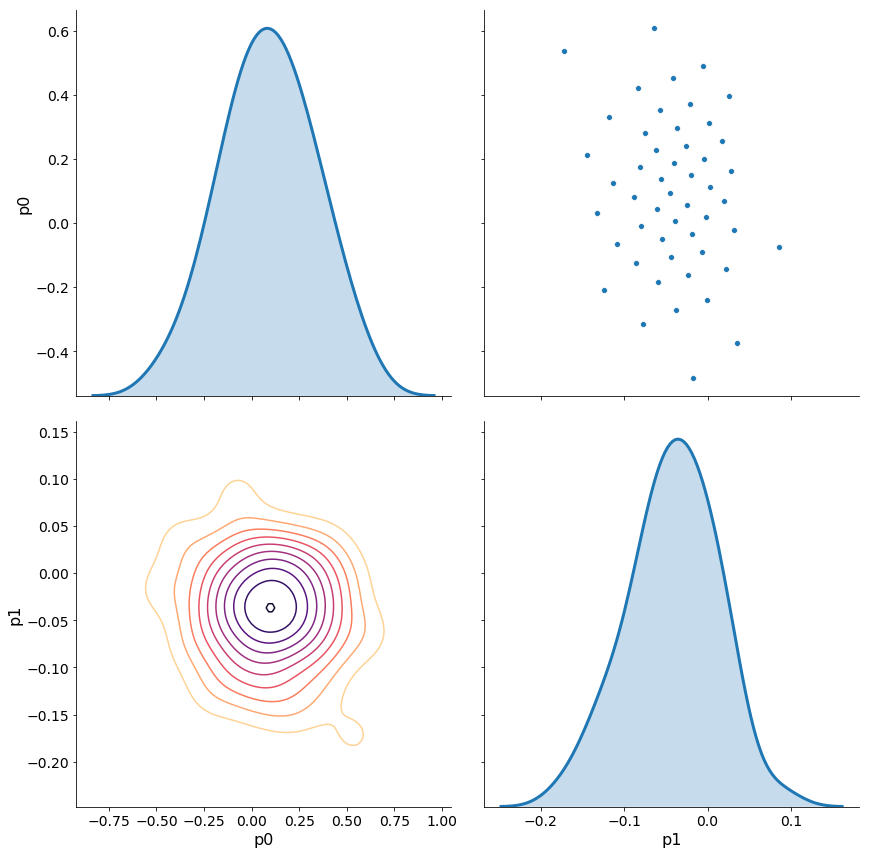

In [910]:
g = sns.PairGrid(sample, diag_sharey=False, height=6)
g.map_lower(sns.kdeplot, cmap='magma_r')
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3, shade=True, )

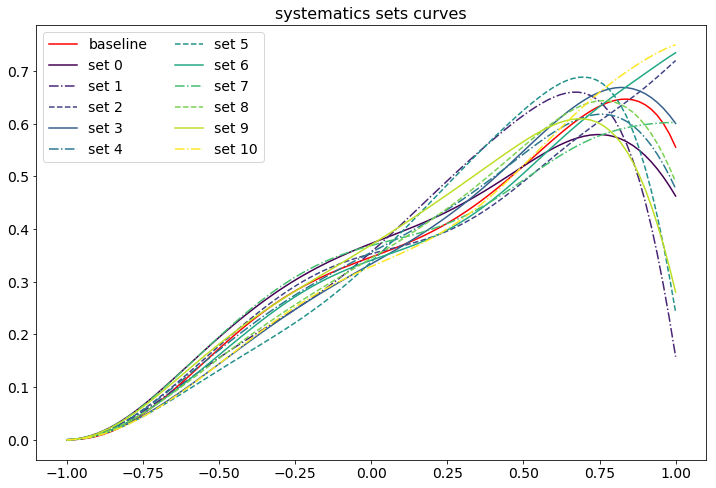

In [983]:
N = 11

colors = cm.viridis(np.linspace(0,1,N))
ls = ['-','-.','--']

#for i, (m, c) in enumerate(models.items()):
#    plt.plot(eta, c, label=m, c=colors[i], ls=ls[i%len(ls)])

plt.plot(eta, models['baseline'], label='baseline', c='r', ls='-')
    
for i in range(N):
    coef = angsens_poly(sample.loc[i].values)
    newf = polynomial.Polynomial(coef[1:])
    plt.plot(eta, newf(eta), label='set %i'%i, c=colors[i], ls=ls[i%len(ls)])

plt.legend(ncol=2)
plt.title('systematics sets curves')
plt.savefig('sys_curves.png')

In [999]:
sample

,p0,p1
0,-0.064805,-0.108849
1,-0.483907,-0.017120
2,0.280321,-0.075404
3,0.112231,0.003502
4,-0.049899,-0.054374
5,-0.372924,0.034933
6,0.296566,-0.036394
7,0.124492,-0.113280
8,-0.035508,-0.018598
9,-0.314209,-0.077367


In [1011]:
# write as files
for i in range(len(sample)):
    with open('sys_models/as.set%i'%i, 'w') as f:
        f.write('\n'.join([str(c) for c in angsens_poly(sample.loc[i].values)]))

